In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import utils.plotting_tools as plot

import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median

from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP, COBYLA
from qiskit.algorithms import VQE
from qiskit import Aer

import cirq

from qiskit.providers.aer import AerError

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham_f = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham_f)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069412+0j) [] +
(-0.02581025441479853+0j) [X0 X1 Y2 Y3] +
(-0.012799934786443133+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.025159645839890558+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.012799934786443133+0j) [X0 X1 X3 X4] +
(-0.025159645839890558+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.0171145288217779+0j) [X0 X1 Y4 Y5] +
(-0.0009891049103738438+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.0009891049103738438+0j) [X0 X1 X5 X6] +
(-0.05469856574685784+0j) [X0 X1 Y6 Y7] +
(0.02581025441479853+0j) [X0 Y1 Y2 X3] +
(0.012799934786443133+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.025159645839890558+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.012799934786443133+0j) [X0 Y1 Y3 X4] +
(-0.025159645839890558+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.0171145288217779+0j) [X0 Y1 Y4 X5] +
(0.0009891049103738438+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.0009891049103738438+0j) [X0 Y1 Y5 X6] +
(0.05469856574685784+0j) [X0 Y1 Y6 X7] +
(0.0025779051793652225+0j) [X0 Z1 X2] +
(0.0047661481056796235+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923297846+0j) [X0 Z1 X2 X3 Z4 

UCCSD ansatz: 
 0.006478936130101918j [X0 X1 X2 Y3] +
0.006478936130101918j [X0 X1 Y2 X3] +
0.0020562744029716347j [X0 X1 X4 Y5] +
0.0020562744029716347j [X0 X1 Y4 X5] +
0.005083283191416462j [X0 X1 X6 Y7] +
0.005083283191416462j [X0 X1 Y6 X7] +
-0.006478936130101918j [X0 Y1 X2 X3] +
0.006478936130101918j [X0 Y1 Y2 Y3] +
-0.0020562744029716347j [X0 Y1 X4 X5] +
0.0020562744029716347j [X0 Y1 Y4 Y5] +
-0.005083283191416462j [X0 Y1 X6 X7] +
0.005083283191416462j [X0 Y1 Y6 Y7] +
-0.0063603900477864975j [X0 Z1 Y2] +
-0.00264541187373439j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709262298j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130101918j [Y0 X1 X2 X3] +
0.006478936130101918j [Y0 X1 Y2 Y3] +
-0.0020562744029716347j [Y0 X1 X4 X5] +
0.0020562744029716347j [Y0 X1 Y4 Y5] +
-0.005083283191416462j [Y0 X1 X6 X7] +
0.005083283191416462j [Y0 X1 Y6 Y7] +
-0.006478936130101918j [Y0 Y1 X2 Y3] +
-0.006478936130101918j [Y0 Y1 Y2 X3] +
-0.0020562744029716347j [Y0 Y1 X4 Y5] +
-0.0020562744029716347j [Y0 Y1 Y4 X5] +
-0.0

In [3]:
hamiltonian = qonvert.QubitOperator_to_dict(ham_q, num_qubits)#
terms_noncon = c_tools.greedy_dfs(hamiltonian, 1, criterion='weight')[-1]

In [4]:
order = [6, 7, 0, 1, 2, 3, 4, 5]
circs = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, order, rot_A=True)
mol1 = c.cs_vqe(hamiltonian, terms_noncon, num_qubits, rot_G=True, rot_A=True)
mol2 = c.cs_vqe(hamiltonian, terms_noncon, num_qubits, rot_G=True, rot_A=False)
print(mol1.generators()[1], mol2.generators()[1])

{'IIIIIIZI': -1.0} {'IZZZZZXI': -0.040172186744742266, 'IIIIIIZI': 0.999192771897468}


In [5]:
order = [6, 7, 0, 1, 2, 3, 4, 5]
circs = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, order, rot_A=True)
mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits, rot_G=True, rot_A=True)
A = mol.generators()[1]
#A_sim=[]
#ucc_terms={}
#for i in ucc.keys():
#    ucc_terms[i] = ucc[i]
#    A_sim.append(circs.CS_VQE(ucc_terms, 8, A)[0])

#fig, ax = plt.subplots(1, 1)
#ax.plot(list(range(len(A_sim))), A_sim)
#ax.set_ylim(0,1.1)
#ax.get_yaxis().get_major_formatter().set_useOffset(False)
print('Expectation Value of A:', circs.CS_VQE(['IIIIYYYY', 'YYYYIIII', 'IXIXIXIX'], 8, A))

#mol.init_state()

*Performing CS-VQE over the following qubit positions: (7, 6, 5, 4, 3, 2, 1, 0)


/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


Expectation Value of A: {'num_sim_q': 8, 'result': -0.9993199878951323, 'target': -1.0000000000000009, 'counts': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,

In [6]:
cs_vqe_results = circs.run_cs_vqe(ucc, max_sim_q = 4, iters=3)

*Performing CS-VQE over the following qubit positions: (1,)
*Performing CS-VQE over the following qubit positions: (1,)
*Performing CS-VQE over the following qubit positions: (1,)


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


*Performing CS-VQE over the following qubit positions: (1, 0)
*Performing CS-VQE over the following qubit positions: (1, 0)
*Performing CS-VQE over the following qubit positions: (1, 0)
*Performing CS-VQE over the following qubit positions: (7, 1, 0)
*Performing CS-VQE over the following qubit positions: (7, 1, 0)
*Performing CS-VQE over the following qubit positions: (7, 1, 0)
*Performing CS-VQE over the following qubit positions: (7, 6, 1, 0)
*Performing CS-VQE over the following qubit positions: (7, 6, 1, 0)
*Performing CS-VQE over the following qubit positions: (7, 6, 1, 0)


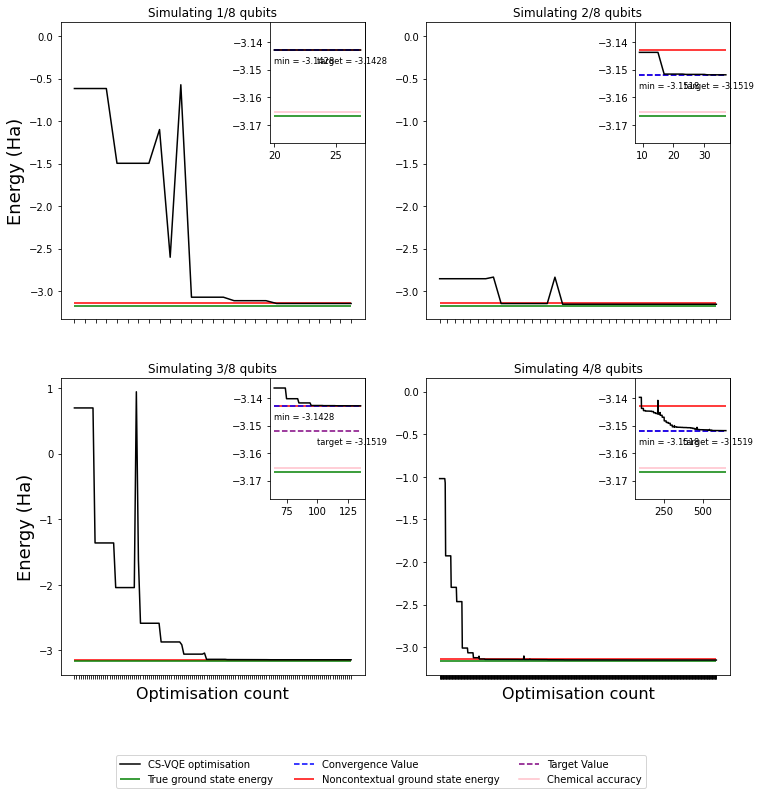

In [7]:
fig = plot.plot_cs_vqe_convergence(data=cs_vqe_results)

In [8]:
G = (mol.generators())[0]
generators = list(G.keys())

In [9]:
rotations = [tuple(r) for r in deepcopy(circs.rotations)]
rot_red = []
for r, p in rotations:
    blank_op = ['I' for i in range(3)]
    for i, sim_i in enumerate((1, 0, 7)):
        blank_op[i] = p[sim_i]
    if r == 'pi/2':
        r = np.pi/4
        
    rot_red.append((''.join(blank_op), r))
        
rot_red

[('ZYZ', 1.5306133271860012),
 ('IYI', 0.7853981633974483),
 ('IYI', 0.7853981633974483),
 ('YII', 0.7853981633974483),
 ('YIZ', 0.7853981633974483),
 ('ZII', 0.7853981633974483)]

In [10]:
list(circs.reduce_anz_terms(ucc, 2).values())

[-0.0009221551709262298j,
 0.0009221551709262298j,
 0j,
 0.010166566382832923j,
 -0.010166566382832923j,
 0j,
 -0.0009221551709262298j,
 0.0009221551709262298j]

In [11]:
c_order = [6,0,1,2,3,4,5]
initial_state = mol.init_state()
results={}
shots=20

eig_proj = la.eigenstate_projector(A, num_qubits)
nan_check = []

for index in range(num_qubits):
    removed_index = list(range(index))
    removed_index.reverse()
    removed_generators = [generators[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    nc_proj = la.noncon_projector(initial_state, Z_indices, num_qubits)

    new_ham_noncon, new_ham_context = mol.move_generator(removed_generators)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context)

    results[index] = {}

    results[index]['exact'] = get_ground_state(get_sparse_operator(new_ham_noncon_q, num_qubits).toarray())[0]

    expectations = []
    for r in range(shots):
        #expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
        #                                                          r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
        #                                                          Z_indices=Z_indices,rot=True)
        rand_vec = la.random_vector(2**num_qubits)
        psi = la.apply_projections(rand_vec, [nc_proj, eig_proj])
        expect_noncon = la.expectation(new_ham_noncon_q, psi, num_qubits)
        expectations.append(expect_noncon)
        nc_value = (sum(expectations)/shots).real

    results[index]['+1eig'] = nc_value
    nan_check.append(nc_value)

results

[] []


/mnt/c/Users/Tim/Jupyter Projects/ContextualSubspaceVQE/utils/linalg_tools.py:100: RuntimeWarning: invalid value encountered in true_divide
  psi = psi/norm


['ZIIIIIII'] [0]
['IZIIIIII', 'ZIIIIIII'] [1, 0]
['IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [2, 1, 0]
['IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [3, 2, 1, 0]
['IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [4, 3, 2, 1, 0]
['IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [5, 4, 3, 2, 1, 0]
['IIIIIIIZ', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [7, 5, 4, 3, 2, 1, 0]


{0: {'exact': -3.1428247492681685, '+1eig': nan},
 1: {'exact': -2.6012614653936623, '+1eig': nan},
 2: {'exact': -1.9622383749331902, '+1eig': nan},
 3: {'exact': -1.858388926936708, '+1eig': nan},
 4: {'exact': -1.6193748661184657, '+1eig': nan},
 5: {'exact': -1.35235357414566, '+1eig': nan},
 6: {'exact': -0.9140090584791554, '+1eig': nan},
 7: {'exact': -0.004014803451954936, '+1eig': -0.004014803451954924}}

[(-3.1428247492681685, -2.6012614653936623, -1.9622383749331902, -1.858388926936708, -1.6193748661184657, -1.35235357414566, -0.9140090584791554, -0.004014803451954936), (nan, nan, nan, nan, nan, nan, nan, -0.004014803451954924)]


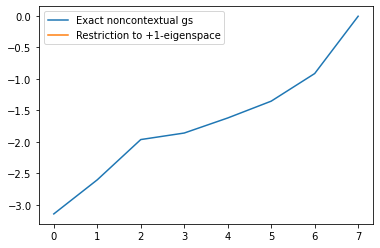

In [12]:
X=range(num_qubits)
values = list(zip(*[list(results[i].values()) for i in X]))
print(values)
Y1=values[0]
Y2=values[1]
#axs[grid].set_title(str(h))
plt.plot(X, Y1, label='Exact noncontextual gs')
plt.plot(X, Y2, label='Restriction to +1-eigenspace')
plt.legend()

In [13]:
#fig.savefig("plots/HeH+-CS-VQE-uccsd_ansatz.png", dpi=300)

In [14]:
#data={}
#for k in cs_vqe_results.keys():
#    data[str(k)] = cs_vqe_results[k]
#        
#json.dumps(data)

In [15]:
#import json 
#     
#with open("data/HeH+_3-21G_UCCSD_CS_VQE_results.json", "w") as outfile: 
#    json.dump(data, outfile)

In [16]:
#circs.build_circuit(['IXIXIXIX'], 8).draw()

In [17]:
#cs_vqe_plot = plot.plot_cs_vqe_convergence(hamiltonian, terms_noncon, ucc, num_qubits, order, 4, rot_A=True)

In [18]:
generators

['ZIIIIIII',
 'IZIIIIII',
 'IIZIIIII',
 'IIIZIIII',
 'IIIIZIII',
 'IIIIIZII',
 'IIIIIIIZ']

In [19]:
A

{'IIIIIIZI': -1.0}

In [20]:
from qiskit.quantum_info.operators import Operator, Pauli
# Create an operator
P1 = Operator(Pauli(label='IZZZZZXI'))
P2 = Operator(Pauli(label='IIIIIIZI'))

# Add to a circuit
circ = QuantumCircuit(8)
circ.append(0.618*P1+0.618*P2,[0,1,2,3,4,5,6,7])
circ.draw()

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/quantum_info/operators/symplectic/pauli.py:187: DeprecationWarning: Initializing Pauli from `Pauli(label=l)` kwarg is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. Use `Pauli(l)` instead.
  base_z, base_x, base_phase = self._from_label_deprecated(label)


ExtensionError: 'Input matrix is not unitary.'

In [ ]:
print(eig.eigenstate(A, 16, num_qubits).construct())
print(eig.eigenstate(A, 18, num_qubits).construct())

In [ ]:
I_op = openfermion.ops.QubitOperator.identity()
A_op = qonvert.dict_to_QubitOperator(A)
A_array = get_sparse_operator(A_op, n_qubits=8).toarray()

In [ ]:
psi = la.random_complex_vector(2**8)
projector = get_sparse_operator((A_op+I_op)/2, n_qubits=8).toarray()

In [ ]:
psi_sub = np.dot(projector, psi)
psi_conj = np.conjugate(psi_sub)
norm = np.sqrt(np.dot(psi_conj, psi_sub))

In [ ]:
psi_sub = psi_sub/norm
psi_conj = np.conjugate(psi_sub)
np.dot(psi_conj, psi_sub)

In [ ]:
la.expectation(A_op, psi_sub, 8)

In [ ]:
conj_psi = np.conjugate(psi)
conj_psi.dot(psi)

In [ ]:
type(projector)

In [ ]:
qc=QuantumCircuit(2,1)
qc.h(0), qc.h(1)
qc.cx(1,0)
qc.reset(1)
qc.measure_all()
qc.draw()


# execute the quantum circuit
backend = BasicAer.get_backend('qasm_simulator') # the device to run on
result = execute(qc, backend, shots=1000).result()
counts  = result.get_counts(qc)
print(counts)
plot_histogram(counts)

In [ ]:
test_list=[(0, 2, 4), (5, 2, 3), (3, 1, 8)]

In [ ]:
sorted([i for i in test_list], key=lambda i:i[0])

In [ ]:
circs.qubit_map(7)

In [ ]:
circs.reference_state()

In [ ]:
qc = QuantumCircuit(2) # We are redefining qc
initial_state = [1/2, 1/2, 1/2, 1/2]
qc.initialize(initial_state)
qc.measure_all()
qc.save_statevector()
qc.draw()

In [ ]:
initial_state = mol.init_state()

bit.unconstrain(initial_state, [7])

In [ ]:
num_sim_q = 3
sim_indices=[7,1,0]

In [ ]:
bin_strings = list(itertools.product([0, 1], repeat=num_sim_q))

In [ ]:
keep_indices=[]
for b in bin_strings:
    bin_expand = list(zip(b, sim_indices))
    keep_indices.append(sum([a*2**b for a, b in bin_expand]))
    
keep_indices       

In [ ]:
ucc.values()